# Toy Model: Filtering

In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pickle
import pandas as pd

# my preferred settings
mpl.rc('lines',linewidth = 1.5)
mpl.rc('font',size = 14)
mpl.rc('axes',labelsize = 16, linewidth=1.25)
mpl.rc('xtick',labelsize = 16)
mpl.rc('ytick',labelsize = 16)
plt.rcParams['savefig.dpi'] = 400 
# enable math fonts
mpl.rc('mathtext', default = 'regular')

from sbin.sbin import suppression_factor, suppression_factor_simple, suppression_simulation
from sbin import parameters

## Read in the data

### Data from Sullivan, Gaia/Bedell, KOIs, KIC

In [7]:
# read in my kois table
with open('tables/kois+gaia.pkl', 'rb') as file:
        kois = pd.read_pickle(file)

# confirmed planets only
allbin = Table.read('tables/plan_allbinall.mrt', format='ascii.mrt').to_pandas()

mask = allbin['Alternate'].str.match(r'^KOI\d+(?:\.\d+)?$', na=False)
tmp = allbin.loc[mask].copy()
tmp['KOI'] = tmp['Alternate'].str.extract(r'KOI0*(\d+)', expand=False).astype(int)
db=tmp.merge(kois, on='KOI', suffixes=['','_y'])

## Review sample properties

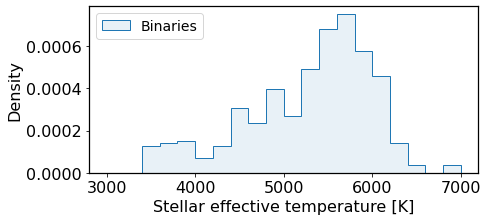

In [9]:
nbins = 20
histrange = (3000,7000)
fig, axes = plt.subplots(1, 1, figsize=(7,3.3), sharex=True, sharey=True)

plt.hist(db['teff'], label='Binaries',
             range=histrange, bins=nbins, density=True, 
             histtype='stepfilled',  edgecolor='#1f77b4', facecolor='#e8f1f7')


plt.ylabel('Density')
plt.xlabel('Stellar effective temperature [K]')
plt.legend(loc='upper left')
plt.tight_layout()


In [10]:
q = db['Mass']/db['Mass_1']
RL = 0.49*q**(2/3)/(0.6*q**(2/3)+np.log(1+q**(1/3))) # verified against https://dev.adsabs.harvard.edu/scan/
disk = RL * db['semi-major']

db['DiskAU'] = disk

db['SnowAU'] = 0.00465*0.5*(db['teff']/170.)**2 # for T_eq = 170K

## Define subsamples

In [11]:
# period and stellar limits
plim = (db['koi_period'] < 100) & (db['teff']<6500) & (db['teff']>4000) 
       

# filter the binaries
db_filtered = db[(db['koi_prad'] < parameters.radius_limit) & (db['koi_prad'] > 0.6) & plim].copy()
close = db_filtered['semi-major']<200
good = (db_filtered['koi_prad_err1'] - db_filtered['koi_prad_err2'])/db_filtered['koi_prad'] < parameters.max_radius_error




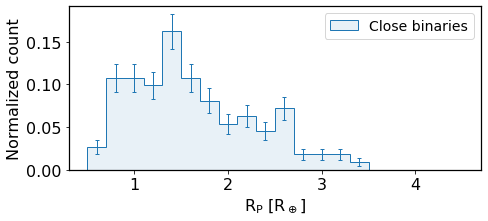

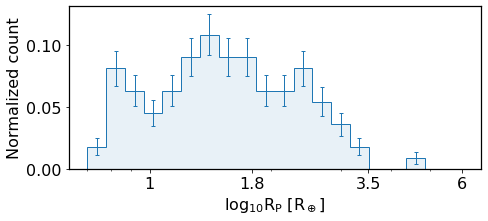

In [12]:

for option in ['linear','log']:

    nbins=20

    if option=='linear':
        histrange=[0.5,4.5]
        bin_edges = np.linspace(histrange[0], histrange[1], nbins + 1)
    else:
        histrange=[np.log10(0.7),np.log10(6)]
        bin_edges = np.logspace(histrange[0], histrange[1], nbins + 1)
        
    bin_width = np.diff(bin_edges)
    bin_center = bin_edges[:-1]+bin_width/2.
        
    fig, axes = plt.subplots(1, 1, figsize=(7,3.3), sharex=True, sharey=True)

    nplanets = len(db_filtered[good & close])
    ww = 1./np.full(nplanets, nplanets, dtype=float)
    # planets with good radii in binary systems with rho<100 au and planet period < 100 days
    y, _, _ = plt.hist(db_filtered['koi_prad'][good & close], 
                  bins=bin_edges, weights=ww,
             histtype='stepfilled', edgecolor='#1f77b4', facecolor='#e8f1f7',
            label='Close binaries')

    plt.errorbar(bin_center, y, np.sqrt(y)/len(y), ls='None', lw=1, capsize=2, c='C0')

    plt.ylabel('Normalized count')
    
    if option=='linear':
        plt.legend()
        plt.xlabel('$R_P$ [$R_\oplus$]')        
    else:
        plt.xlabel('$log_{10} R_P$ [$R_\oplus$]')  
        plt.xscale('log')
        
        custom_log_ticks = [1, 1.8, 3.5, 6]
        plt.gca().set_xticks(custom_log_ticks)
        plt.gca().set_xticklabels([str(t) for t in custom_log_ticks])
        
    plt.tight_layout()
    #plt.savefig('prad-'+option+'.png')

    plt.xlim()

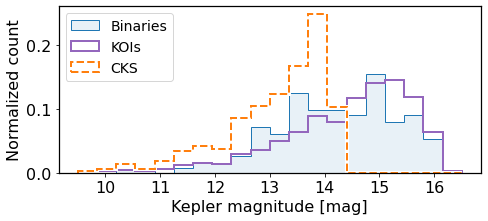

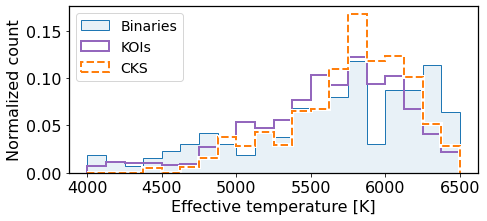

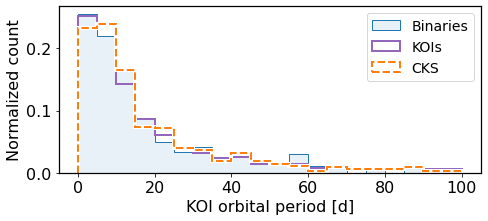

In [52]:
nbins = 20

for col_name in ['koi_kepmag','teff','koi_period']:
    
    db_col_name = col_name    
    hloc = 'upper left'
    if col_name=='koi_kepmag':
        histrange = (9.5,16.5)
        xlabel = 'Kepler magnitude [mag]'

    elif col_name=='teff':
        histrange = (4000,6500)
        xlabel = 'Effective temperature [K]'
        db_col_name = 'Teff1'
        
    else:
        histrange=(0,100)
        hloc = 'upper right'
        xlabel = 'KOI orbital period [d]'
        
    fig, axes = plt.subplots(1, 1, figsize=(7,3.3), sharex=True, sharey=True)

    nplanets = len(db_filtered[good])
    ww = 1./np.full(nplanets, nplanets, dtype=float)
    plt.hist(db_filtered[db_col_name][good], weights=ww,
             label='Binaries',
                 range=histrange, bins=nbins, 
                 histtype='stepfilled',  edgecolor='#1f77b4', facecolor='#e8f1f7')

    
    plt.ylabel('Normalized count')
    plt.xlabel(xlabel)
    plt.legend(loc=hloc)
    plt.tight_layout()
    plt.savefig(col_name+'.png')


In [13]:
bundle = {
    "db_filtered": db_filtered,      # pandas DataFrame
    "close": close,                  # boolean Series
    "good": good,                    # boolean Series
}

with open("filtered_data_thebault.pkl", "wb") as f:
    pickle.dump(bundle, f, protocol=pickle.HIGHEST_PROTOCOL)


## Get numbers for paper

In [53]:
def calc_statistics(catalog, prad_col = 'Rp', star_col='KOI', MTPS=False):
    
    n_planets = float(len(catalog))
    print( "Number of planets: ", int(n_planets))
    print( "Number of stars: ", len(catalog[star_col].unique()))
    
    n_SEs = float(len(catalog.loc[catalog[prad_col]<parameters.radius_valley]))
    print("Frac super-Earths/n_planets: ", n_SEs/n_planets, "+-", np.sqrt(n_SEs)/n_planets)
    
    if MTPS:
        planet_counts = catalog.groupby(star_col).size().reset_index(name='n_planets')
        stps = len(planet_counts.loc[planet_counts['n_planets']==1])
        mtps = len(planet_counts.loc[planet_counts['n_planets']>1])
        print("Frac MTPS: ", mtps, stps, mtps/(stps+mtps), "+-", np.sqrt(mtps)/(stps+mtps))


# ----------------------------------------------
# Print all the samples and sub-samples
# ----------------------------------------------

        
print("BINARIES\n\n All")
calc_statistics(db_filtered[good], prad_col='Rppri')

print("\n Close (error good)")
calc_statistics(db_filtered[good & close], prad_col='Rppri')

print("\n Wide (error good)")
calc_statistics(db_filtered[good & ~close], prad_col='Rppri')

print("\n Close (any error)")
calc_statistics(db_filtered[close], prad_col='Rppri', MTPS=True)

print("\n Wide (any error)")
calc_statistics(db_filtered[~close], prad_col='Rppri', MTPS=True)


print("\n\nSINGLE KOIS")
print("\n (err < lim)")
calc_statistics(kois_filtered[kois_good], prad_col='koi_prad')
print("\n (any err)")
calc_statistics(kois_filtered, prad_col='koi_prad', MTPS=True)
print("\nSINGLE CKS")
print("\n (err < lim)")
calc_statistics(cks_filtered[cks_good])
print("\n (any err)")
calc_statistics(cks_filtered, MTPS=True)

BINARIES

 All
Number of planets:  263
Number of stars:  204
Frac super-Earths/n_planets:  0.5095057034220533 +- 0.044014588983993255

 Close (error good)
Number of planets:  117
Number of stars:  91
Frac super-Earths/n_planets:  0.5811965811965812 +- 0.07048043804474634

 Wide (error good)
Number of planets:  146
Number of stars:  113
Frac super-Earths/n_planets:  0.4520547945205479 +- 0.05564409866189014

 Close (any error)
Number of planets:  121
Number of stars:  93
Frac super-Earths/n_planets:  0.5702479338842975 +- 0.06864978399105846
Frac MTPS:  20 73 0.21505376344086022 +- 0.048087483387092254

 Wide (any error)
Number of planets:  150
Number of stars:  117
Frac super-Earths/n_planets:  0.4533333333333333 +- 0.05497474167490214
Frac MTPS:  22 95 0.18803418803418803 +- 0.04008902358823444


SINGLE KOIS

 (err < lim)
Number of planets:  2744
Number of stars:  2010
Frac super-Earths/n_planets:  0.48833819241982507 +- 0.01334038281175155

 (any err)
Number of planets:  2799
Number 

### Investigate trends

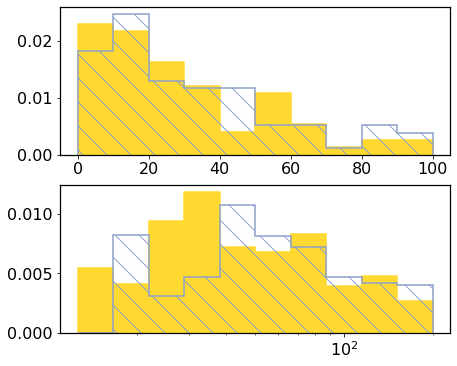

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(7,6), sharex=False, sharey=False)

max_rp = db_filtered.loc[db_filtered.groupby('KOI')['Rppri'].idxmax()].reset_index(drop=True)
db_small = max_rp[max_rp['Rppri']<=parameters.radius_valley].copy()
db_large = max_rp[max_rp['Rppri']>parameters.radius_valley].copy()

    
axes[0].hist(db_large['DiskAU']/db_large['SnowAU'], 
             range=(0,100), histtype='step', density=True,
             edgecolor='#8da0cb', facecolor='#8da0cb', hatch="\\", linewidth=1.5, 
             label='Large planet hosts')
axes[0].hist(db_small['DiskAU']/max_rp['SnowAU'], 
             range=(0,100), hatch='', density=True,
             edgecolor='#ffd92f', facecolor='#ffd92f',  linewidth=1.5,
             label='Small planet hosts')
# how many times bigger is the disk than the snow line


# defining the limits of the semi-major axis
a_values = np.logspace(1.1,2.3, 100)
bins = np.logspace(np.log10(a_values.min()), np.log10(a_values.max()), 11)

axes[1].hist(db_large['SepAU'],
             bins=bins, histtype='step', density=True,
             edgecolor='#8da0cb', facecolor='#8da0cb', hatch="\\",  linewidth=1.5, 
             label='Large planet hosts')
axes[1].hist(db_small['SepAU'], 
             bins=bins, density=True,
             edgecolor='#ffd92f', facecolor='#ffd92f',  linewidth=1.5)
axes[1].set_xscale('log') # Set the x-axis to logarithmic scale

plt.show()



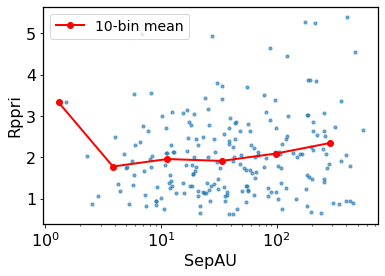

In [24]:
# scatter 
y = max_rp['DiskAU']/max_rp['SnowAU']
plt.scatter(y, max_rp['Rppri'], s=10, alpha=0.6)
plt.xscale('log')
plt.xlabel('SepAU'); plt.ylabel('Rppri')

# 10 log-spaced bins (11 edges)
#bins = np.logspace(np.log10(20), np.log10(3000), 11)
bins = np.logspace(np.log10(0.01), np.log10(500), 11)

# assign points to bins
bin_idx = np.digitize(y.values, bins)

# keep only points inside [bins[0], bins[-1]]
valid = (bin_idx >= 1) & (bin_idx <= len(bins) - 1)
tmp = max_rp.loc[valid, ['Rppri']].copy()
tmp['bin'] = bin_idx[valid]

# mean Rppri per bin, ensure length 10 (fill missing bins with NaN)
means = tmp.groupby('bin')['Rppri'].mean().reindex(range(1, len(bins))).values

# plot at bin centers (geometric mean of edges)
centers = np.sqrt(bins[:-1] * bins[1:])
plt.plot(centers, means, color='red', linewidth=2, marker='o', label='10-bin mean')

plt.legend()
plt.show()

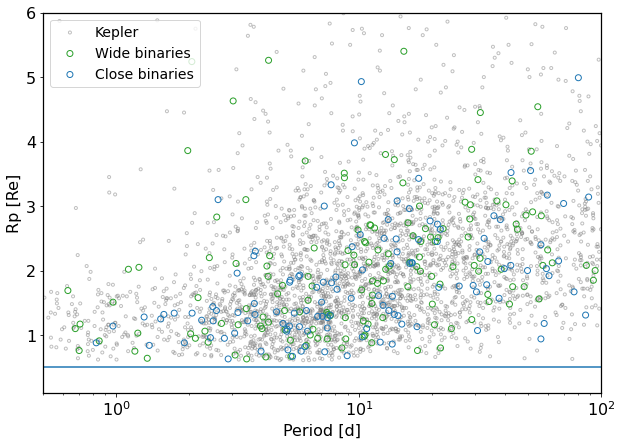

In [25]:
plt.figure(figsize=(10,7))
plt.scatter(kois_filtered['koi_period'], kois_filtered['koi_prad'], marker='.',
         edgecolor='gray', alpha=0.5, lw=1, facecolor='None', label='Kepler')

plt.scatter(db_filtered['koi_period'][~close], db_filtered['Rppri'][~close] ,
         edgecolor='C2', facecolor='None', lw=1, label='Wide binaries')
plt.scatter(db_filtered['koi_period'][close], db_filtered['Rppri'][close] ,
         edgecolor='C0', lw=1, facecolor='None', label='Close binaries')


plt.xlim(0.5,100)
plt.ylim(0.1,6)
plt.axhline(0.5)
plt.xscale('log')
plt.xlabel('Period [d]')
plt.ylabel('Rp [Re]')
plt.legend()

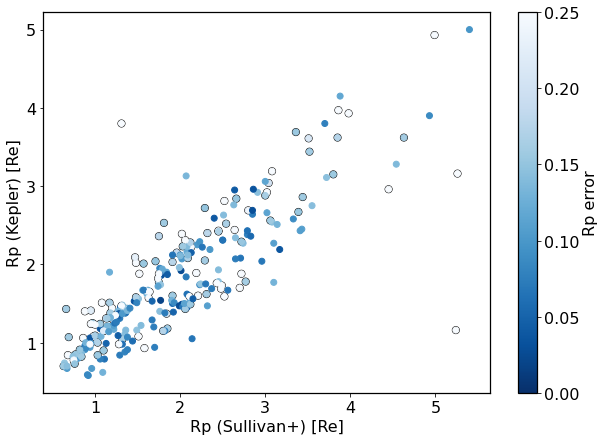

In [26]:
plt.figure(figsize=(10,7))
err = db_filtered['e_Rpkep']/db_filtered['koi_prad']
plt.scatter(db_filtered['Rppri'][err>0.15], db_filtered['koi_prad'][err>0.15], lw=2, edgecolor='k', facecolor='None')
plt.scatter(db_filtered['Rppri'], db_filtered['koi_prad'], c=err, 
            cmap='Blues_r', vmin=0, vmax=0.25)
plt.xlabel('Rp (Sullivan+) [Re]')
plt.ylabel('Rp (Kepler) [Re]')
plt.colorbar(label='Rp error')
plt.show()

# Overview

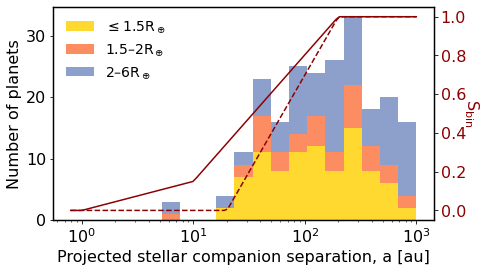

In [27]:
# ----------------------------------------------
# Set-up
# ----------------------------------------------

fig, ax1 = plt.subplots(figsize=(7, 4))

# defining the limits of the semi-major axis
a_values = np.logspace(-0.1,3, 100)
bins = np.logspace(np.log10(a_values.min()), np.log10(a_values.max()), 20)

# calculate suppression factors
S_values = suppression_factor(a_values)
S_values2 = suppression_factor_simple(a_values)


# ----------------------------------------------
# First axis -- histogram of planet radii
# ----------------------------------------------


# define the samples
ses = db_filtered['SepAU'][(db['Rppri']<=1.5)] # super-Earths
ppp = db_filtered['SepAU'][(db['Rppri']>1.5) & (db['Rppri']<2) ] # in-betweens
mns = db_filtered['SepAU'][(db['Rppri']>=2) & (db['Rppri']<6) ] # mini-Neptunes

# plot the histograms
ax1.hist([ses, ppp, mns], bins=bins,
         alpha=1, color=['#ffd92f','#fc8d62','#8da0cb'], 
         stacked = True, label=[
                f'$\leq1.5 R_\\oplus$',
                f'$1.5 – 2 R_\\oplus$',
                f'$2 – 6 R_\\oplus$'])

ax1.set_xscale('log') # Set the x-axis to logarithmic scale
ax1.set_ylabel('Number of planets', color='k')
ax1.tick_params(axis='y', labelcolor='k')

ax1.set_xlabel('Projected stellar companion separation, a [au]')
plt.legend(edgecolor='None', facecolor='w')


# ----------------------------------------------
# Second axis -- the suppression equation
# ----------------------------------------------

ax2 = ax1.twinx()

ax2.plot(a_values, S_values, color='darkred', linestyle='-', label='Suppression Factor')
ax2.plot(a_values, S_values2, color='darkred', linestyle='--', label='Suppression Factor')
ax2.tick_params(axis='y', labelcolor='darkred')

ax2.set_ylabel('$S_\mathrm{bin}$', rotation=270, color='darkred', labelpad=15)


# ----------------------------------------------
# Adjust and save
# ----------------------------------------------

plt.xscale('log')
#plt.title('Suppression function from Moe & Kratter')
#plt.grid(True)
plt.tight_layout()
plt.savefig('overview.png')

(array([ 3.,  4., 10., 10., 22., 25., 48., 54., 73., 56., 27., 36., 29.,
        19.,  6.,  0.,  4.,  2.,  0.,  1.]),
 array([0.31  , 0.3805, 0.451 , 0.5215, 0.592 , 0.6625, 0.733 , 0.8035,
        0.874 , 0.9445, 1.015 , 1.0855, 1.156 , 1.2265, 1.297 , 1.3675,
        1.438 , 1.5085, 1.579 , 1.6495, 1.72  ]),
 <BarContainer object of 20 artists>)

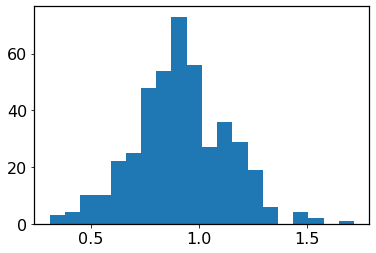

In [51]:
plt.hist(db['Mass'], bins=20)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


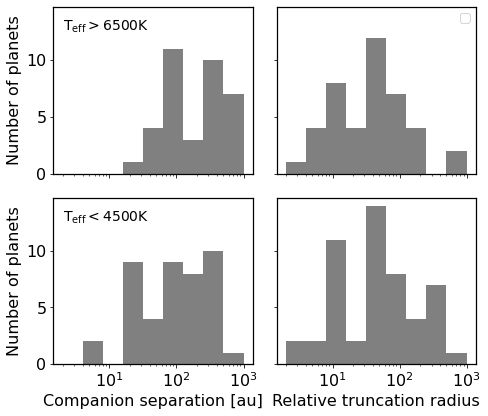

In [56]:
# ----------------------------------------------
# Set-up
# ----------------------------------------------


# defining the limits of the semi-major axis
a_values = np.logspace(0.3,3, 100)
bins = np.logspace(np.log10(a_values.min()), np.log10(a_values.max()), 10)

# calculate suppression factors
S_values = suppression_factor(a_values)
S_values2 = suppression_factor_simple(a_values)


# ----------------------------------------------
# First axis -- histogram of planet radii
# ----------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)

for xi in [0,1]:
    
    for tj in [0,1]:
        
        if xi==1:
            x = db['DiskAU']/db['SnowAU']
        else:
            x = db['semi-major']
            
        if tj == 0:
            # define the samples
            temp=r'$T_{eff}>6500 K$'
            mns = x[(db['Mass']>1.2)] # mini-Neptunes
        else:
            temp=r'$T_{eff}<4500 K$'
                # define the samples
            mns = x[(db['Mass']<0.7)] # mini-Neptunes


 
        axes[tj,xi].hist(mns, bins=bins,
             alpha=1, color='gray')
        axes[tj,xi].set_xscale('log') # Set the x-axis to logarithmic scale
        axes[tj,xi].tick_params(axis='y', labelcolor='k')

        if xi==1:
            #axes[tj,xi].text(0.95, 0.93, temp, 
            #     horizontalalignment='right', verticalalignment='top', transform=axes[tj,xi].transAxes)            
            if tj==1:
                axes[tj,xi].set_xlabel('Relative truncation radius')
            else:
                axes[tj,xi].legend(fontsize=12)
        else:
            axes[tj,xi].text(0.05, 0.93, temp, 
                 horizontalalignment='left', verticalalignment='top', transform=axes[tj,xi].transAxes)            
            axes[tj,xi].set_ylabel('Number of planets', color='k')
            if tj==1:
                axes[tj,xi].set_xlabel('Companion separation [au]')
    
    #plt.legend(edgecolor='None', facecolor='w')




    # ----------------------------------------------
    # Adjust and save
    # ----------------------------------------------

    plt.xscale('log')
    #plt.title('Suppression function from Moe & Kratter')
    #plt.grid(True)
    plt.tight_layout()
    plt.savefig('snowline-binall.png')